In [ ]:
import torch
import torch.nn as nn
from torchview import draw_graph
from einops import rearrange
from tqdm import tqdm
import torch.nn.functional  as Fn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from io import BytesIO
from IPython.display import Image as IPyImage, display
from PIL import Image
import matplotlib.pyplot as plt

import wandb
wandb.login()

In [ ]:
wandb.init(
    project="VQVAE-Transformer",  
    name="experiment-1",    
    id="fe9htihr",  # Same ID as before
    resume="allow"
    config={                       
        "epochs": 100,
        "batch_size": 16,
    }
)

# wandb.init(
#     project="experiment-1",
#     id="VQVAE-Transformer",  # Same ID as before
#     resume="allow"  # or "must"
# )

Implementation
https://www.youtube.com/watch?v=1mi2MSvigcc&t=18s

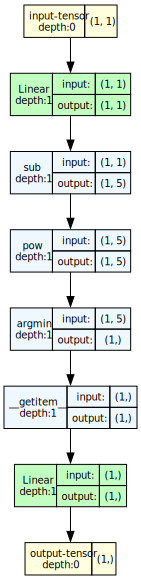

In [6]:
class VQVAEQuantizeWithoutDerivative(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(1, 1)
        self.codebook = nn.Parameter(torch.tensor([-5., -9., 0., 6., 9.]))
        self.decoder = nn.Linear(1, 1)

    def forward(self, x):
        encoder_out = self.encoder(x)
        l2_difference = (encoder_out - self.codebook) ** 2
        nearest_index = torch.argmin(l2_difference, dim = -1)
        # print(nearest_index)
        decoder_input = self.codebook[nearest_index]
        # print(decoder_input)
        decoder_out = self.decoder(decoder_input)
        return decoder_out

q = VQVAEQuantizeWithoutDerivative()
test = torch.ones(1).unsqueeze(0)
out = q(test)
# print(out)
out.backward()
model_graph = draw_graph(q, input_size = (1, 1))
model_graph.visual_graph

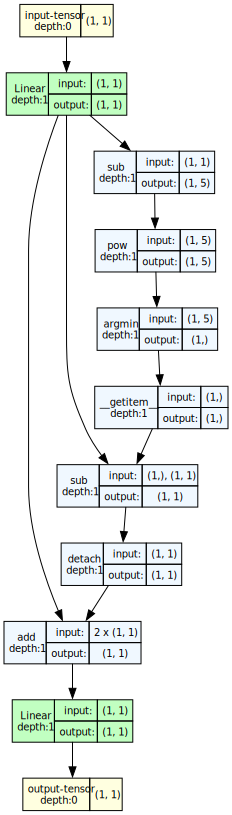

In [7]:
class VQVAEQuantizeWithDerivative(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(1, 1)
        self.codebook = nn.Parameter(torch.tensor([-5., -9., 0., 6., 9.]))
        self.decoder = nn.Linear(1, 1)

    def forward(self, x):
        encoder_out = self.encoder(x)
        l2_difference = (encoder_out - self.codebook) ** 2
        nearest_index = torch.argmin(l2_difference, dim = -1)
        # print(nearest_index)
        decoder_input = self.codebook[nearest_index]
        # print(decoder_input)
        decoder_input = encoder_out + (decoder_input - encoder_out).detach()
        decoder_out = self.decoder(decoder_input)
        return decoder_out

q = VQVAEQuantizeWithDerivative()
test = torch.ones(1).unsqueeze(0)
out = q(test)
# print(out)
out.backward()
model_graph = draw_graph(q, input_size = (1, 1))
model_graph.visual_graph

In [52]:
class VectorQuantizeImage(nn.Module):
    def __init__(self, codeBookDim = 64, embeddingDim = 32, decay = 0.99, eps = 1e-5):
        super().__init__()

        self.codeBookDim = codeBookDim
        self.embeddingDim = embeddingDim
        self.decay = decay
        self.eps = eps

        self.codebook = nn.Embedding(codeBookDim, embeddingDim)
        nn.init.xavier_uniform_(self.codebook.weight.data)

        self.register_buffer('ema_Count', torch.zeros(codeBookDim))
        self.register_buffer('ema_Weight', self.codebook.weight.data.clone())

    def forward(self, x):
        x_reshaped = x.view(-1, self.embeddingDim)

        distance = (torch.sum(x_reshaped**2, dim=1, keepdim=True) 
                    + torch.sum(self.codebook.weight**2, dim=1)
                    - 2 * torch.matmul(x_reshaped, self.codebook.weight.t()))
        
        encoding_indices = torch.argmin(distance, dim=1) 
        encodings = Fn.one_hot(encoding_indices, self.codeBookDim).type(x_reshaped.dtype)
        quantized = torch.matmul(encodings, self.codebook.weight)

        if self.training:
            self.ema_Count = self.decay * self.ema_Count + (1 - self.decay) * torch.sum(encodings, 0)
            
            x_reshaped_sum = torch.matmul(encodings.t(), x_reshaped.detach())
            self.ema_Weight = self.decay * self.ema_Weight + (1 - self.decay) * x_reshaped_sum
            
            n = torch.clamp(self.ema_Count, min=self.eps)
            updated_embeddings = self.ema_Weight / n.unsqueeze(1)
            self.codebook.weight.data.copy_(updated_embeddings)

        
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # quantized = x + (quantized - x).detach()

        return quantized, encoding_indices, perplexity
        
        
vq = VectorQuantizeImage(codeBookDim=64,embeddingDim=32)
rand = torch.randn(1024,32)
vq(rand)   

(tensor([[-0.0109,  0.1786, -0.0845,  ..., -0.1966,  0.0871,  0.2342],
         [-0.1458, -0.1642, -0.0300,  ..., -0.2130, -0.1846, -0.1496],
         [-0.0961,  0.2081,  0.0385,  ...,  0.0300, -0.0332,  0.0712],
         ...,
         [-0.1837,  0.0764, -0.1859,  ...,  0.1913,  0.0171,  0.1789],
         [ 0.2107,  0.0715,  0.0630,  ...,  0.0220, -0.2299,  0.2445],
         [-0.2481, -0.0982,  0.2325,  ..., -0.1347, -0.1603, -0.2351]],
        grad_fn=<MmBackward0>),
 tensor([19, 53, 63,  ...,  8, 24,  6]),
 tensor(59.4609))

In [53]:
class VecQVAE(nn.Module):
    def __init__(self, inChannels = 1, hiddenDim = 32, codeBookdim = 128, embedDim = 128):
        super().__init__()
        self.inChannels = inChannels
        self.hiddenDim = hiddenDim
        self.codeBookdim = codeBookdim
        self.embedDim = embedDim

        self.encoder = nn.Sequential(
            nn.Conv2d(inChannels, hiddenDim, 4, 2, 1), 
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, 2 * hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(2 * hiddenDim, 2 * hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(2 * hiddenDim, embedDim, 1),
        )

        self.vector_quantize = VectorQuantizeImage(codeBookDim=codeBookdim,embeddingDim=embedDim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedDim, 2 * hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(2 * hiddenDim, 2 * hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(2 * hiddenDim, hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, inChannels, 1),
            nn.Sigmoid()
        )

    def encodeImage(self, x):
        encodedOut = self.encoder(x)
        return encodedOut;

    def decodeImage(self, quantized_vector):
        decodedOut = self.decoder(quantized_vector)
        return decodedOut

    def forward(self, x):
        batch_size, inChannels, height, width = x.shape
        encodedOut = self.encodeImage(x)
        batch_size, encoded_channel, encoded_height, encoded_width = encodedOut.shape
        
        # print(f"Encoded Shape: {encodedOut.shape}")

        
        vectorize_input = rearrange(encodedOut, 'b c h w -> (b h w) c')
        quantized_vectors, encoding_indices, perplexity  = self.vector_quantize(vectorize_input)
        codebook_loss = Fn.mse_loss(vectorize_input.detach(), quantized_vectors)
        commitment_loss = Fn.mse_loss(vectorize_input, quantized_vectors.detach())

        quantized_vectors = vectorize_input + (quantized_vectors - vectorize_input).detach()
        # print(f"CodeBook Loss: {codebook_loss} , Commitment Loss: {commitment_loss}")
        # print(f"Quantized SHape: {quantized_vectors.shape}")

        decoder_input = rearrange(quantized_vectors, '(b h w) d -> b d h w', d = encoded_channel, h = encoded_height, w = encoded_width)
        # print(f"Decoded Input SHape: {decoder_input.shape}")
        decodedOut = self.decodeImage(decoder_input)

        # print(f"Decoded SHape: {decodedOut.shape}")
        
        return decoder_input, decodedOut, codebook_loss, commitment_loss, encoding_indices, perplexity

VQ = VecQVAE(inChannels = 1, hiddenDim = 128, codeBookdim = 64, embedDim = 32)
test = torch.randn(32, 1, 64, 64)
quantized_latents, decoderOut, codebook_loss, commitment_loss, encoding_indices, perplexity = VQ(test)
quantized_latents.shape, decoderOut.shape, codebook_loss, commitment_loss, encoding_indices.shape, perplexity

(torch.Size([32, 32, 16, 16]),
 torch.Size([32, 1, 64, 64]),
 tensor(0.1375, grad_fn=<MseLossBackward0>),
 tensor(0.1375, grad_fn=<MseLossBackward0>),
 torch.Size([8192]),
 tensor(26.4422))

In [16]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
print(data.shape)
data = np.transpose(data, (1, 0, 2, 3))
data = torch.from_numpy(data)
data = data.unsqueeze(2)
data.shape

(20, 10000, 64, 64)


torch.Size([10000, 20, 1, 64, 64])

In [17]:
class MakeFrameDataset(Dataset):
    def __init__(self, video, input_length=10, output_length=10):
        super().__init__()
        num_videos, num_frames, C, H, W = video.shape
        self.frames = video.reshape(-1, C, H, W)
        

    def __len__(self):
        return self.frames.shape[0]

    def __getitem__(self, idx):
        frame = self.frames[idx]
        return frame, frame
    
test = torch.randn(32, 20, 1, 64, 64)
out = MakeFrameDataset(test)
x, y = out.__getitem__(0)
x.shape, y.shape

(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

In [54]:
codeBookdim = 64
embedDim = 32
hiddenDim = 128
inChannels = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torchDataset = MakeFrameDataset(data)
dataloader = DataLoader(torchDataset, batch_size=64, shuffle = True)
modelA = VecQVAE(inChannels = inChannels, hiddenDim = hiddenDim, codeBookdim = codeBookdim, embedDim = embedDim).to(device)
lossFn = nn.MSELoss()#VecVAELoss(betaValue = 0.25)
optimizerA = torch.optim.Adam([
                    {'params': modelA.encoder.parameters(), 'lr': 2e-4},
                    {'params': modelA.decoder.parameters(), 'lr': 2e-4},
                    {'params': modelA.vector_quantize.parameters(), 'lr': 1e-4}
                ], weight_decay=1e-5)
schedulerA = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizerA, T_0=10, T_mult=2, eta_min=1e-6
            )

epochs = 1000

In [ ]:
# modelValA = torch.load("./model/VQVAE/vqvae.pt", map_location=torch.device('cpu'))
# modelA.load_state_dict(modelValA)

for each_epoch in range(epochs):
    modelA.train()
    reconstruct_loss = 0.0
    codeb_loss = 0.0
    commit_loss = 0.0
    
    vqvaeloss = 0.0
    loop = tqdm(dataloader, f"{each_epoch}/{epochs}")

    for X, Y in loop:
        X = X.to(device)
        Y = Y.to(device)
        
        quantized_latents, decoderOut, codebook_loss, commitment_loss, encoding_indices, perplexity = modelA(X)
        reconstruction_loss = torch.mean((Y - decoderOut)**2)
        
        perplexity_loss = -torch.log(perplexity + 1e-10)
        loss = reconstruction_loss + codebook_loss + 0.25 * commitment_loss + 0.01 * perplexity_loss
        vqvaeloss += loss.item()

        
        reconstruct_loss += reconstruction_loss.item()
        codeb_loss += codebook_loss.item()
        commit_loss += commitment_loss.item()
        
        optimizerA.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelA.parameters(), max_norm=1.0)
        optimizerA.step()
        loop.set_postfix({"TotalL": f"{vqvaeloss}", "ReconsL": f"{reconstruct_loss}", "CodeL":f"{codeb_loss}",
                          "CommitL":f"{commitment_loss}", "Perplexity":f"{perplexity}"})
    #     break
    # break

    vqvaeloss /= len(dataloader)   
    reconstruct_loss /= len(dataloader)   
    codeb_loss /= len(dataloader)   
    commit_loss /= len(dataloader)   
    torch.save(modelA.state_dict(), "./model/VQVAE/vqvae.pt")
    wandb.log({
        "Epoch": each_epoch,
        "VQVAE LR": optimizerA.param_groups[0]['lr'],
        "VQVAE Loss": vqvaeloss,
        "Reconstruction Loss": reconstruct_loss,
        "Codebook Loss": codeb_loss,
        "Commitment Loss": commit_loss
        # "Perplexity": perplexity
    })
    schedulerA.step()
 

In [21]:
modelValA = torch.load("./model/VQVAE/vqvae.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)

<All keys matched successfully>

In [22]:
data[0, 0, ...].shape

torch.Size([1, 64, 64])

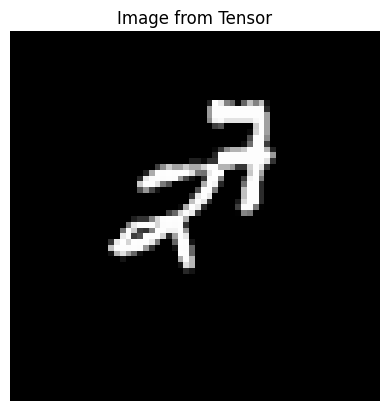

In [23]:
# test_image = torch.randn(1, 1, 64, 64)
temp_image = data[0, 10, ...].squeeze()
image_np = temp_image.numpy().astype(np.uint8)
image = Image.fromarray(image_np, mode='L') 

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Image from Tensor")
plt.show()

In [24]:
test_data = data[0, 10, ...].unsqueeze(0)/255.0
test_data.shape

torch.Size([1, 1, 64, 64])

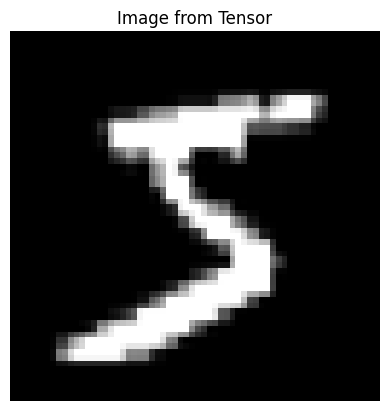

torch.Size([1, 1, 64, 64])

In [49]:
img = Image.open("image.png")
img = img.convert("L")

img = img.resize((64, 64))

img_array = np.array(img)#.reshape((1, 64, 64))
img_array = np.array(img).astype(np.float32)  # shape: (64, 64)

img_array.shape

tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0)


plt.imshow(img_array, cmap='gray')
plt.axis('off')
plt.title("Image from Tensor")
plt.show()
tensor.shape

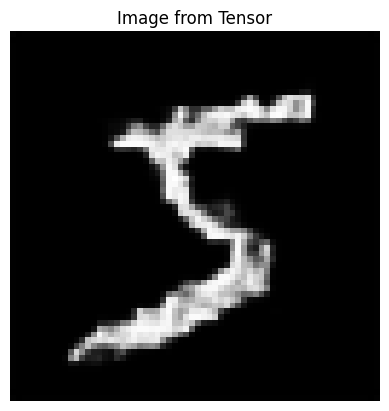

In [51]:
out_image, _, _, _, _ = modelA(tensor/255.0)
out_image = modelA.decodeImage(out_image)
out_image = out_image.squeeze()
image_np = (out_image * 255).clamp(0, 255).byte().cpu().numpy()

image = Image.fromarray(image_np, mode='L') 

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Image from Tensor")
plt.show()

In [6]:
class Transformer(nn.Module):
    def __init__(self, vocab_size=512, seq_length = 10, embed_dim=256, num_heads=4, feed_forward_dim=512):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.seq_length = seq_length
        
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_length, embed_dim, embed_dim))
        
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=feed_forward_dim,
            dropout=0.1,
            batch_first=True  # Use batch-first format
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        
        self.output_layer = nn.Linear(embed_dim, 1)

    def forward(self, x):
        
        batch, features = x.shape
        x = rearrange(x, 'b (s e) -> b s e', e = self.embed_dim, s = self.seq_length)
        x = self.embedding(x)
        
        x = x + self.positional_encoding
        x = rearrange(x, 'b s e d -> b (s e) d', e = self.embed_dim, s = self.seq_length)
        x = self.encoder(x)
        x = self.output_layer(x)
        
        x = rearrange(x, 'b s e -> b (s e)')
        
        return x

 
tr = Transformer()
test = torch.randint(0, 10, (2, 2560))

out = tr(test)
print(out.shape)

torch.Size([2, 2560])


In [7]:
class MakeVideoDataset(Dataset):
    def __init__(self, video, input_length=10, output_length=10):
        super().__init__()
        self.video = video
        self.input_length = input_length
        self.output_length = output_length
        self.batch_size, self.seq_len, _, _, _ = video.shape

        self.samples_per_video = self.seq_len - input_length - output_length + 1
        self.total_samples = self.batch_size * self.samples_per_video

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        batch_idx = idx // self.samples_per_video
        time_idx = idx % self.samples_per_video

        input_frames = self.video[batch_idx, time_idx:time_idx + self.input_length]
        output_frames = self.video[batch_idx, time_idx + self.input_length:time_idx + self.input_length + self.output_length]

        return (
            torch.tensor(input_frames, dtype=torch.float32),
            torch.tensor(output_frames, dtype=torch.float32)
        )

    
    
test = torch.randn(32, 20, 1, 4, 4)
out = MakeVideoDataset(test)
x, y = out.__getitem__(0)
x.shape, y.shape

/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11585/2549432269.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(input_frames, dtype=torch.float32),
/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11585/2549432269.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(output_frames, dtype=torch.float32)


(torch.Size([10, 1, 4, 4]), torch.Size([10, 1, 4, 4]))

In [8]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
print(data.shape)
data = np.transpose(data, (1, 0, 2, 3))
data = torch.from_numpy(data)
data = data.unsqueeze(2)
data.shape

(20, 10000, 64, 64)


torch.Size([10000, 20, 1, 64, 64])

In [ ]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
torchDataset = MakeVideoDataset(data)
dataloader = DataLoader(torchDataset, batch_size=8, shuffle = True)

transformer_celoss =nn.CrossEntropyLoss()
modelA = Transformer().to(device)
modelB = VecQVAE().to(device)

optimizerA = optim.AdamW(modelA.parameters(), lr=5e-5)
optimizerB = optim.Adam(modelB.parameters(), lr=2e-4)
schedulerA = StepLR(optimizerA, step_size=10, gamma=0.5)  
schedulerB = StepLR(optimizerB, step_size=20, gamma=0.7)  

epochs = 100

In [ ]:
for each_epoch in range(epochs):

    loop = tqdm(dataloader, f"{each_epoch}/{epochs}")
    for datapoint in loop:
        # print(datapoint[0].shape, datapoint[1].shape)
        datapoint[0] = datapoint[0]/255.0
        datapoint[1] = datapoint[1]/255.0

        input_indices = []
        output_indices = []
        vqvaeloss = 0.0
        transformer_loss = 0.0
        totalLoss = 0.0

        for each_frame_index in range(datapoint[0].shape[1]):
            each_input_frame = datapoint[0][:, each_frame_index, ...]
            each_input_frame = each_input_frame.to(device)
            out, ez, qz, inputindex = modelB(each_input_frame)
            vqvaeloss += VecQVAELoss(each_input_frame, out, ez, qz)

            each_output_frame = datapoint[1][:, each_frame_index, ...]
            each_output_frame = each_output_frame.to(device)
            out, ez, qz, outputindex = modelB(each_output_frame)
            vqvaeloss += VecQVAELoss(each_output_frame, out, ez, qz)

            input_indices.append(inputindex)
            output_indices.append(outputindex)

        # print(vqvaeloss)
        inputCodeboobIndices = torch.cat(input_indices, dim=-1)
        outputCodeboobIndices = torch.cat(output_indices, dim=-1)
        inputCodeboobIndices = inputCodeboobIndices.to(device)
        outputCodeboobIndices = outputCodeboobIndices.to(device)

        # print(inputCodeboobIndices.shape)
        predX = modelA(inputCodeboobIndices)
        # y = modelA(outputCodeboobIndices)
        # print(predX.shape, inputCodeboobIndices.shape, outputCodeboobIndices.shape)
        
        predX = rearrange(predX, 'b (d l) -> b d l', l = 10)
        outputCodeboobIndices = rearrange(outputCodeboobIndices, 'b (d l) -> b d l', l = 10)

        loss = transformer_celoss(predX, outputCodeboobIndices.float())
        # # transformer_loss += loss.item()

        combined_loss = loss + vqvaeloss
        

        optimizerA.zero_grad()
        optimizerB.zero_grad()

        combined_loss.backward()

        optimizerA.step()
        optimizerB.step()
        loop.set_postfix({"VQVAE Loss": f"{vqvaeloss.item()}", " Transformer Loss": f"{loss.item()}", " Total Loss": f"{combined_loss.item()}"})
        
    # if each_epoch % 5 == 0:
    torch.save(modelA.state_dict(), "./model/VQVAE/transformer.pt")
    torch.save(modelB.state_dict(), "./model/VQVAE/vqvae.pt")
    wandb.log({
        "Epoch": each_epoch,
        "VQVAE Loss": vqvaeloss.item(),
        "Transformer Loss": loss.item(),
        "Total Loss": combined_loss.item(),
        "Transformer LR" : optimizerA.param_groups[0]['lr'],
        "VQVAE LR": optimizerB.param_groups[0]['lr']
    })

    schedulerA.step()
    schedulerB.step()

    

0/50:   0%|          | 0/1250 [00:00<?, ?it/s]/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11585/2549432269.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(input_frames, dtype=torch.float32),
/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11585/2549432269.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(output_frames, dtype=torch.float32)
0/50:   0%|          | 0/1250 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [30]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
data = np.transpose(data, (1, 0, 2, 3))
data.shape

(10000, 20, 64, 64)

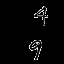

In [36]:
def visualizeData(sequence):

    frames = [Image.fromarray((frame * 255).astype(np.uint8), mode='L') for frame in sequence]

    buffer = BytesIO()
    frames[0].save(
        buffer,
        format='GIF',
        save_all=True,
        append_images=frames[1:],
        duration=100,
        loop=0
    )

    buffer.seek(0)
    display(IPyImage(data=buffer.getvalue()))

visualizeData(data[50])

In [37]:
modelValA = torch.load("model/VQVAE/transformer.pt", map_location=torch.device('mps'))
modelA.load_state_dict(modelValA)

modelValB = torch.load("model/VQVAE/vqvae.pt", map_location=torch.device('mps'))
modelB.load_state_dict(modelValB)


<All keys matched successfully>

In [ ]:
initial_frame = torch.from_numpy(data[0, 10]/255.0)

initial_frame.shape

torch.Size([64, 64])